# Usage
## `networkx` Hierarchy

The International Classification of Disease seperates diseases into chapters, subchapters and so on. `icdcodex` considers each of these as a node in a network -- and provides access to this representation through `networkx`.

In [1]:
from icdcodex import hierarchy
icd_10_cm_hierarchy, icd_10_cm_codes = hierarchy.icd10cm("2020")

The network is unstructured, by default. But we can use `networkx` to do graphical analysis. For instance, we can generate a spring layout of the chapters using breadth first traversal.

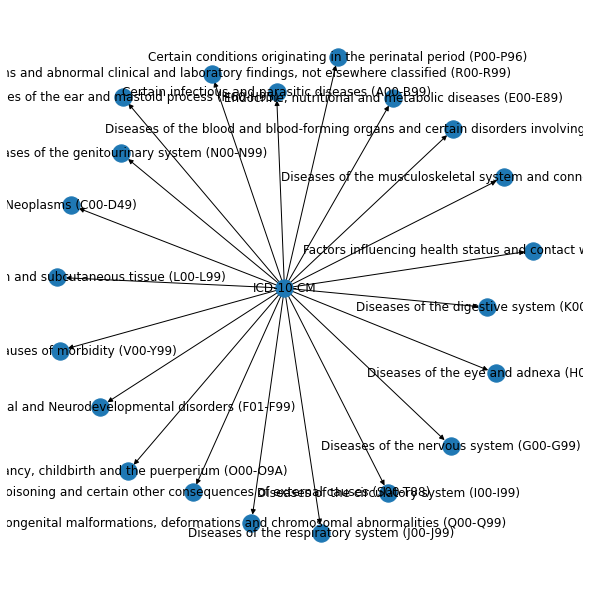

In [2]:
import networkx as nx
from networkx.algorithms.traversal.breadth_first_search import bfs_tree
import matplotlib.pyplot as plt

G = nx.relabel_nodes(icd_10_cm_hierarchy, {"root": "ICD-10-CM"})
G_chapters = bfs_tree(G, "ICD-10-CM", depth_limit=1)
plt.figure(figsize=(8,8))
nx.draw(G_chapters, with_labels=True)

## Vector Embeddings

`icdcodex` uses this graphical structure to build a dense representation of individual codes. So far, we provide the `node2vec` algorithm, accessible through the `icd2vec` module.

In [3]:
from icdcodex import icd2vec, hierarchy
# workers=-1 parallelizes the node2vec algorithm across all available CPUs
embedder = icd2vec.Icd2Vec(num_embedding_dimensions=2, workers=-1)
embedder.fit(*hierarchy.icd9())

Dense representations have the property that similar vectors have similar locations in vector space. For example, `033.0 (Whooping cough due to bordetella pertussis)` and `034.0 (Streptococcal sore throat)` are both bacterial diseases. `910.1 (Abrasion or friction burn of face, neck, and scalp except eye, infected)` is an injury. We expect `034.0` and `033.0` to be closer to one another than to `910.1`

In [6]:
codes_of_interest = ["0330", "0340", "9101"]
codes_of_interest_continuous = embedder.to_vec(codes_of_interest)
codes_of_interest_continuous

array([[ 0.78746617, -1.1355207 ],
       [ 0.7202955 , -0.97387433],
       [ 5.667383  , -0.13091612]], dtype=float32)

## Example: Predicting MIMIC-III diagnostic codes

For a more involved example, we'll build a scikit-learn pipeline. To get our data, we'll use [MIMIC-III](https://mimic.physionet.org/gettingstarted/demo/). A demo version can be accessed through the [GCP Big Query service](https://cloud.google.com/bigquery/) by running `ADD DATA > Pin a project > Enter a project name > 
physionet-data`. Run the SQL query:
    
```sql
SELECT
    i.seq_num, i.subject_id, i.icd9_code, j.los, k.gender, k.dob, k.dod, l.admittime
FROM `physionet-data.mimiciii_demo.diagnoses_icd` as i
    INNER JOIN
        `physionet-data.mimiciii_demo.icustays` as j
        ON i.hadm_id = j.hadm_id
    INNER JOIN
        `physionet-data.mimiciii_demo.patients` as k
        ON i.subject_id = k.subject_id
    INNER JOIN
        `physionet-data.mimiciii_demo.admissions` as l
        ON i.hadm_id = l.hadm_id
```
Then, save the results as `data.csv`.

First, we'll import boilerplate data science libraries

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split

Then, load the data and do feature engineering to give the model something with which to predict ICD codes.

In [8]:
df = pd.read_csv("data.csv").rename(columns={
    "los": "length_of_stay",
    "dob": "date_of_birth",
    "dod": "date_of_death",
    "admittime": "date_of_admission"
})
df["date_of_birth"] = pd.to_datetime(df["date_of_birth"]).dt.date
df["date_of_death"] = pd.to_datetime(df["date_of_death"]).dt.date
df["date_of_admission"] = pd.to_datetime(df["date_of_admission"]).dt.date
df["age"] = df.apply(lambda e: (e['date_of_admission'] - e['date_of_birth']).days/365, axis=1)
df = df[df.seq_num == 1]  # we limit ourselves to the primary diagnosis code for simplicity
df.gender = LabelEncoder().fit_transform(df.gender)
G, icd_codes = hierarchy.icd9()
df = df[df.icd9_code.isin(G.nodes())]
features = ["length_of_stay", "gender", "age"]
X = df[features].values
y = df[["icd9_code"]].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Now, we can use any regression model that can predict a vector, including `RandomForestRegressor`

In [ ]:
from sklearn.ensemble import RandomForestRegressor
y_train_continuous = embedder.to_vec(y_train.reshape(-1))
clf = RandomForestRegressor()
clf.fit(X_train, y_train_continuous)